# Using a random forest to infer past population size
In this example we are going to try to infer the past population size after an instantenous population contraction/expansion. Technically what we are inferring is the ratio of the ancestral size to the current size. We are also assuming the time of the size change is known. Again for the purposes of this simple example we are taking the unusal step of doing some demographic inference when examining one locus rather than many loci, but hopefully the exercise will still be illustrative.

## Preliminaries
The road map here will be to 1) simulate a bunch of loci each with a randomly drawn ancestral population size (which we will record) 2) to train a regressor to infer this size on the basis of a feature vector of summary statistics 3) test our accurracy on a set of simulations not used during training 4) to graphically present how well our trained classifier works.

To do this we will use coalescent simulations as implemented in our Dick Hudson's `ms` and will again use `scikit-learn` for our machine learning. For our statistics, we will use Alistair Miles' `scikit-allel` python package.

(Note: `scikit-allel` is an excellent package for this sort of thing. There are other nice packages that are equally excellent and well suited for our task here, but `scikit-allel` is up and running on the machine I am writing this from so that is what we are using. Don't hate on me, friends!)

### Install and compile `ms`
We have put a copy of the `ms` tarball in this repo, so the following should work upon cloning. (Note that this step is not required if you have already gone through `demographicModelSelectionExample.ipynb`.)

In [4]:
#untar and compile ms and sample_stats
!tar zxf ms.tar.gz; cd msdir; gcc -o ms ms.c streec.c rand1.c -lm
#I get three compiler warnings from ms, but everything should be fine
#now I'll just move the program into the current working dir
!mv msdir/ms .;

### Install `scikit-learn`
If you use anaconda or have gone through any of our other examples, you may already have these modules installed, but if not you can install with either of the following:

In [ ]:
!conda install scikit-learn --yes

or if you don't use `conda`, you can use `pip` to install scikit-learn with

In [ ]:
!pip install -U scikit-learn

### Install `scikit-allel`
See https://scikit-allel.readthedocs.io/en/latest/, but this is easy to do if you have anaconda installed:

In [ ]:
!conda install -c conda-forge scikit-allel --yes

Alternatively, you could use pip, provided you have already installed the following dependencies: numpy, scipy, matplotlib, seaborn, pandas, scikit-learn, h5py, numexpr, bcolz, zarr and dask. 

In [ ]:
!pip install scikit-allel

# Step 1: create a training set and a testing set
We will use `ms` and its `tbs` feature to generate 10000 replicates each with its own randomly selected recombination rate. Let's start by drawing the rates and recording them in a file.

In [2]:
import random

with open("random_pop_size.sizes", "w") as f:
    for i in range(10000):
        #we will let the present:ancient ratio range from 0.1 to 10
        popSize = 10**(random.random()*2-1)
        f.write("%f\n" %(popSize))


Now that we have our rates in hand we will feed them into `ms` and perform our simulations.

In [5]:
#simulate under the various two epoch models where ancient population size is determined at random from list made above
!./ms 20 10000 -t 100 -r 100 10000 -en 0.5 1 tbs  < random_pop_size.sizes > random_pop_size.msOut

Now we have to read in our simulation output and convert it into a data structure used by `scikit-allel` called a HaplotypeArray. The script msTools.py which we have included in this repository does this for us. Then we can calculate our statistics for each replicate. This is slow, so be patient.

(One weird trick: we have to map our polymorphisms from a contiuous space to discrete space in order to use `scikit-allel`. The code below does that but we have to specify a number of sites we are mapping too, which must be greater than the number of polymorphisms. The 10000 sites we specified for `ms`'s recombination routine should suffice.)

In [ ]:
from msTools import *
import numpy as np
import sys, allel

totalPhysLen=10000
hapArraysIn, positionArrays = msOutToHaplotypeArrayIn("random_pop_size.msOut", totalPhysLen)
X = []
for i in range(len(hapArraysIn)):
    if i % 1000 == 0:
        sys.stdout.write("done with %d instances\n" %(i))
    #some of the statistics that we are going to calculate here require a HaplotypeArray as input, made thusly
    haps = allel.HaplotypeArray(hapArraysIn[i], dtype='i1')
    
    #others require an AlleleCountsArray, which contains the minor allele frequencu for each polymorphism
    #First we need to make GenotypeArray as an intermediate
    genos = haps.to_genotypes(ploidy=2)
    ac = genos.count_alleles()
    
    #now we build our feature vector, using various statistics calculated by scikit-allel.
    #for more information on the usage of these see https://scikit-allel.readthedocs.io/en/latest/
    currVec = []
    currVec.append(allel.stats.diversity.tajima_d(ac, pos=positionArrays[i]))# Tajima's D
    currVec.append(allel.stats.diversity.sequence_diversity(positionArrays[i], ac))# pi
    currVec.append(allel.stats.diversity.watterson_theta(positionArrays[i], ac))# theta W
    currVec.append(allel.stats.selection.garud_h(haps)[0])# avg. haplotype homozygosity
    
    X.append(currVec)

X = np.array(X)

#reading in our target output
Y = np.loadtxt("random_pop_size.sizes")

#now split our data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)


In [3]:
#the last step in this process will be to shuffle the data, and then split it into a training set and a testing set
#the testing set will NOT be used during training, and will allow us to check how well the classifier is doing
#scikit-learn has a very convenient function for doing this shuffle and split operation
#
# will will keep out 10% of the data for testing

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)

# Step 2: train our regressor
Now that we have a training and testing set ready to go, we can move on to training our regressor. For this example we will use a random forest regressor as implemented by `scikit-learn`.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

clf = RandomForestRegressor(n_estimators=100,n_jobs=10)
clf.fit(X_train, Y_train)

Piece of cake!

# Step 3: benchmark our classifier
Since we are doing regression, a sensible place to start might be to plot our true versus predicted values on our independent test set.

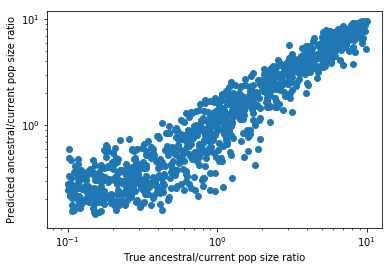

In [5]:
#now the actual work
#first get the predictions
preds=clf.predict(X_test)

#now plot them
import matplotlib.pyplot as plt
fig,ax= plt.subplots(1,1)
ax.scatter(Y_test, preds)
ax.set_xlabel("True ancestral/current pop size ratio")
ax.set_ylabel("Predicted ancestral/current pop size ratio")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

Not too shabby! Let's look at some quantitative measures of this fit. In particular we will look at the mean squared error (lower is better) and the variance explained by the regression (a.k.a. R^2 -- 1 would be perfect)

In [13]:
print 'mean squared error = ',np.mean((preds-Y_test)**2)
print 'R^2 = ', clf.score(X_test, Y_test)

mean square error =  0.489478484226
R^2 =  0.92324762797


So this is doing quite well indeed.